In [1]:
import numpy as np
from pc_kriging import PC_Kriging
from sklearn.gaussian_process import GaussianProcessRegressor # is it needed?
from sklearn.gaussian_process.kernels import RBF # is it needed?
import matplotlib.pyplot as plt
from scipy.stats import norm
from doepy import build
from scipy import optimize
import pandas as pd
from numpy import genfromtxt
import pickle

# adaptive learning - expected feasiability function --------------------------------------------------------------

def EFF(u,v,z):
    zl=-2*v
    zh=2*v
    return ((u-z)*( 2*norm.cdf((z-u)/v) - norm.cdf((zl-u)/v) - norm.cdf((zh-u)/v)) 
           -(v)*( 2*norm.pdf((z-u)/v) - norm.pdf((zl-u)/v) - norm.pdf((zh-u)/v))  
           +(2*v)*(norm.cdf((zh-u)/v) - norm.cdf((zl-u)/v)))

def U_function(u, v):
    return np.abs(u)/v

def LinearNorm(x,oldmin,oldmax,newmin,newmax):    # scaling linearly X to new domain limits
    return newmin + ((x-oldmin)*(newmax-newmin)/(oldmax-oldmin))

## Loading experiments from simulator

In [2]:
#columns=["Angle", "Velocity", "Dleg", "Dbra", "Flowstress", "YoungMod", "timetoStop", "Penetration", "MaxForce"])   
#initial sampling
dataset= genfromtxt('10p_LSH_Vel_sigma.csv' , delimiter=',') 
test = genfromtxt('1000_LHS_VelSig.csv' , delimiter=',') 

In [3]:
dim = 2
n = dataset.shape[0]
ntest = test.shape[0]

xn = np.zeros((int(n), dim))      #normalized training points
xr = np.zeros((int(n), dim))      #scaled training points
yn = np.zeros((int(n)))      #observations
#------------------------------------------------------------
XN = np.zeros((int(ntest), dim))      #normalized TEST points
XR = np.zeros((int(ntest), dim))      #scaled TEST points
YN = np.zeros((int(ntest)))      #TEST observations
#------------------------------------------------------------
#retrieving input observations-------------------------------
#TRAIN -------------------------
xr[:,0] = dataset[:,1]    #velocity
xr[:,1] = dataset[:,4]    #flowStress
yn = dataset[:,7]         #penetration
#TEST -------------------------
XR[:,0] = test[:,1]    #velocity
XR[:,1] = test[:,4]    #flowStress
YN = test[:,7]         #penetration

### Creating object

In [4]:
config = {"pol_type": ['hermite', 'hermite']}   #design variables following normal distribution

In [5]:
PCK1 = PC_Kriging(config)

In [6]:
x1min = np.max(dataset[:,1])    #min velocity
x1max = np.min(dataset[:,1])    #max velocity
x2min = np.min(dataset[:,4])    #min flowstress
x2max = np.max(dataset[:,4])    #max flowstress

x1mean, x1sigma = 1.5 , 1.0     # VELOCITY for normal distribution 
x2mean, x2sigma = 317e6 , 30e6  # FlowStress for normal distribution 

xn[:,0] = (xr[:,0] - x1mean)/ x1sigma
xn[:,1] = (xr[:,1] - x2mean)/ x2sigma
XN[:,0] = (XR[:,0] - x1mean)/ x1sigma
XN[:,1] = (XR[:,1] - x2mean)/ x2sigma

In [ ]:
%matplotlib notebook

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XR[:,0],XR[:,1], YN)
ax.set_xlabel('Velocity')
ax.set_ylabel('FlowStress')
ax.set_zlabel('Penetration')

Objective function

In [ ]:
# objective function to optimize length scale --------------------------------------------------------
def L_Object (l):
    v=5/2
    N=len(xn)
    R = PCK1.matern(xn , xn, l, v)
    detR = np.linalg.det(R)
    
    modelpar2 = PCK1.train(xn, yn, p, np.array([l,v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
    ### ------------------Theta_ by UQLab User Manual PCK(C. Lataniotis, D. Wicaksono, S. Marelli, B. Sudret)------------------------------
    sig2 = modelpar2[1].reshape(-1)
    # return 0.5*(np.log(detR)+ N*np.log(2*np.pi*sig2)+ N)

    ### ------------------Theta_ by MLE PCK(Schobi,Sudret,Wiart)------------------------------
    FB = modelpar2[2] @ modelpar2[0]
    ins = (yn-FB).reshape(-1)
    R_1 = np.linalg.inv(R)
    return ((ins.T) @ R_1 @ ins) * (1/N) * (detR**(1/N))

In [ ]:
#optimizing kernell-hyperparameters and fitting GP regressor with Scikit-learn package----------------------------
kernel = 1 * RBF(length_scale=1.5, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(xn, yn)
ke= gaussian_process.kernel_
print("kernel 1   :",ke)

## Training the model

In [22]:
#train model -----------------------------------------

# kernel hyperparameters------------------------------
l = 1.0213 #length scale
v = 5/2    #matern coefficient
theta = np.array([l,v])

#truncation term-------------------------------------
p = 2  #for each variable → same truncation , degree of expansion

modelpar1 = PCK1.train(xn, yn, p, theta)    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
modelpar1[0], modelpar1[1]   ## B, sig2,

(array([ 0.63014834, -0.05072013, -0.02230104,  0.53567664, -0.06163471,
         0.04922883]),
 0.0001438803769512934)

Optimizing parameters (length scale)

In [ ]:
dist = PCK1.distance(xn, xn)
lmax = np.max(dist)
lmin = np.min(dist[dist!=0])

results = dict()
bounds = [(lmin, lmax)]

results['shgo'] = optimize.shgo(L_Object, bounds)   #bounds must be a list [lmin, lmax]
results['DA'] = optimize.dual_annealing(L_Object, bounds)
results['DE'] = optimize.differential_evolution(L_Object, bounds)

bounds, results['shgo']['x'], results['DA']['x'],results['DE']['x']

### Generating prediction points

In [9]:
# # model predictions -----------------------------------------

# ntest = 30  # test points
# seed = 0      # fixing seed random number generator
# np.random.seed(seed)         #fixing seed random number generator

# # test points -------------------------------------------------
# XN = np.zeros((int(ntest), dim))  #normalized test points
# XR = np.zeros((int(ntest), dim))  #scaled test points 
# #variable 1 ---------------------------------------------------
# XN[:,0] = np.random.normal(0,1,ntest)
# XR[:,0] = PCK1.scalehermite(XN[:,0],x1mean,x1sigma)  
# # XR[:,0] = PCK1.scalelegendre(XN[:,0].reshape(-1,), x1min, x1max) 
# #variable 2 ---------------------------------------------------
# XN[:,1] = np.random.normal(0,1,ntest)  
# XR[:,1] = PCK1.scalehermite(XN[:,1],x2mean,x2sigma)  

# Mtest = function(XR)    #test points
mean1,var1 = PCK1.predict(XN)

Export the model

In [23]:
#save model
filename = 'Surrogate_PCK_2p.sav'
pickle.dump(PCK1, open(filename, 'wb'))

In [18]:
#load model
loaded_model = pickle.load(open(filename, 'rb'))

In [19]:
#make predictions with new model----
#NORMALIZE XN values
mean2,var2 = loaded_model.predict(XN)

### Predicting

<IPython.core.display.Javascript object>


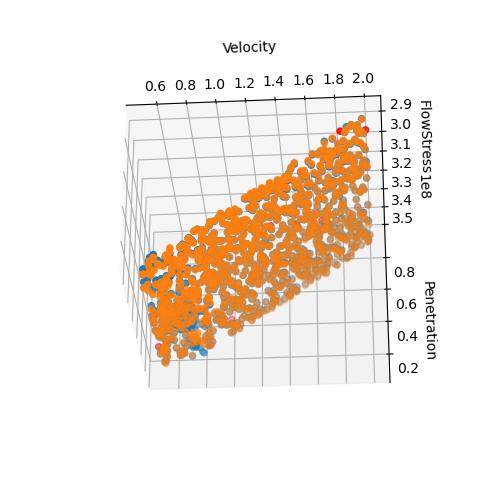

Text(0.5, 0, 'Penetration')

In [21]:
%matplotlib notebook

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XR[:,0],XR[:,1], YN)
ax.scatter(XR[:,0],XR[:,1], mean2)
ax.scatter(xr[:,0],xr[:,1], yn, color='red')
ax.set_xlabel('Velocity')
ax.set_ylabel('FlowStress')
ax.set_zlabel('Penetration')

In [ ]:
#predictions over a grid (for plotting)--------------------------------------------------

# X1t, X2t = np.meshgrid(np.sort(XN[:,0]), np.sort(XN[:,1])) #grid over normalized points
# Xt = np.stack((X1t,X2t),axis=2).reshape(-1,2) #sorting the random sampling (graphing purpose)

# X1m, X2m = np.meshgrid(np.sort(XR[:,0]), np.sort(XR[:,1])) #grid over non-normalized points
# Xtm = np.stack((X1m,X2m),axis=2).reshape(-1,2) #sorting the random sampling (graphing purpose)

# yt = function(Xtm)    #test points
# Mtest = yt[0]

# response1 = PCK1.predict(Xt, xn, y, theta, modelpar1)   #model predictions over (ntest x ntest) points
# mean1 = response1[0]
# var1 = response1[1]

In [ ]:
z=0    #target value

eff1 = np.zeros(ntest)

eff1 = EFF(np.squeeze(mean1),var1,z)

U_f = U_function(mean1.reshape(-1), var1.reshape(-1))

# mean1[-1], var1[-1], U_f[-1]

# mean1[0], var1[0], U_f[0]

In [ ]:
ymin=(mean1 - 1.96*(var1.reshape(-1,1))**0.5)
ymax=(mean1 + 1.96*(var1.reshape(-1,1))**0.5)

# sorting in case of random samples for ploting

ind=np.argsort(np.squeeze(XR))
a,b,c=np.asarray(XR)[ind], np.asarray(ymin)[ind], np.asarray(ymax)[ind]

#%matplotlib notebook 
fig, ax1 = plt.subplots(figsize=(16,10))

ax2=ax1.twinx()


# fig = plt.figure(figsize=(15,8))
# ax=fig.add_axes([0,0,1,1])
ax1.scatter(XR,Mtest,label=r"trueF",color='grey',s=5)
# plt.scatter(XR,mean1,label=r"PC trend",color='blue',s=5)
ax1.scatter(XR,mean1,label=r"PCK",color='g',s=7)
ax1.scatter(xr, y, label="Observations",marker="x",color='r',s=200)
ax1.legend(prop={'size': 10})
ax1.fill_between(
    a.ravel(),
    b.ravel(),
    c.ravel(),
    alpha=0.3,
    label=r"95% Confidence interval",
)

ax2.plot(XR,eff1,label="EFF",linestyle='dashed',linewidth=1,color='k')
# ax2.plot(XR,U_f,label="U",linestyle='dashed',linewidth=1,color='b')

ax1.axhline(z,label="Target", color='red', linestyle='dashed',linewidth=1)
ax1.legend(prop={'size': 11})
ax2.legend(prop={'size': 11})
# ax2.set_ylim(0,1)
# plt.xlim([0, 1.75])
# plt.ylim([-20.0, 20.0])

Function to graph the evolution Theta varying 'length scale'

In [ ]:

def Lscale (l):
    v=5/2
    detR = np.zeros(len(l))
    theta = np.zeros(len(l))
    sig2 = np.zeros(len(l))
    
    N=len(xn)
    

    for i in range(0, len(l)):       
        R = PCK1.matern(xn , xn, l[i], v)
        detR[i] = np.linalg.det(R)
        modelpar2 = PCK1.train(xn, y, p, np.array([l[i],v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
        sig2[i] = modelpar2[1].reshape(-1)
        
        # theta[i] = 0.5*(np.log(detR[i])+ N*np.log(2*np.pi*sig2[i])+ N)

        ### ------------------Theta_ by MLE PCK(Schobi,Sudret,Wiart)------------------------------
        FB = modelpar2[2] @ modelpar2[0]
        ins = (y-FB).reshape(-1)
        R_1 = np.linalg.inv(R)
        theta[i] = ((ins.T) @ R_1 @ ins) * (1/N) * (detR[i]**(1/N))

    return theta , detR, sig2

In [ ]:
def L_Object (l):
    v=5/2
    N=len(xn)
    R = PCK1.matern(xn , xn, l, v)
    detR = np.linalg.det(R)

    modelpar2 = PCK1.train(xn, y, p, np.array([l,v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)

    sig2 = modelpar2[1].reshape(-1)
    # return 0.5*(np.log(detR)+ N*np.log(2*np.pi*sig2)+ N)

    ### ------------------Theta_ by MLE PCK(Schobi,Sudret,Wiart)------------------------------
    FB = modelpar2[2] @ modelpar2[0]
    ins = (y-FB).reshape(-1)
    R_1 = np.linalg.inv(R)
    return ((ins.T) @ R_1 @ ins) * (1/N) * (detR**(1/N))

In [ ]:
Graph_bound = np.array([lmin, lmax])
xlength=np.linspace(Graph_bound[0], Graph_bound[1], 1000)
theta, detR, sig2 = Lscale(xlength)


fig = plt.figure(figsize=(15,8))
plt.plot(xlength, theta)
plt.grid()
plt.show